In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import qriemannopt as qro

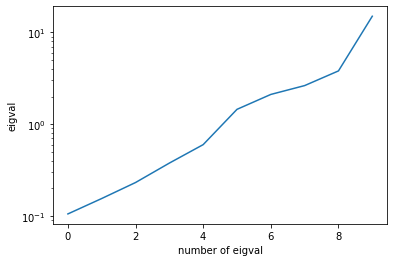

In [10]:
ham_dim = 10 # dimension of hamiltonian

# hamiltonian
Q = qro.manifold.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)
S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.exp(S)
S = tf.cast(S, dtype=tf.complex128)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

plt.plot(tf.linalg.eigvalsh(H))
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('eigval')

# min of loss function
min_value = tf.cast(tf.linalg.eigvalsh(H)[0],
                   dtype=tf.float64)

# in dens matrix
rho = tf.eye(ham_dim, dtype=tf.complex128)
rho = rho / tf.linalg.trace(rho)
rho = qro.manifold.complex_to_real(rho)

# manifold of dens matrices
m = qro.manifold.DensM()

# optimizers
opts = {
        'GD':qro.optimizers.RSGD(m, 0.01),
        'GD_momentum':qro.optimizers.RSGD(m, 0.01, 0.9),
        'Adam':qro.optimizers.RAdam(m, 0.01),
        'Adam_with_ams':qro.optimizers.RAdam(m, 0.01, ams=True)
       }

In [13]:
list_of_losses = {}
# loop over optimizers
for key, opt in opts.items():
    # training loop
    losses = []
    rho_var = tf.Variable(rho)
    for _ in range(1000):
        with tf.GradientTape() as tape:
            loss = tf.linalg.trace(qro.manifold.real_to_complex(rho_var) @ H)
            loss = tf.cast(loss, tf.float64)
            losses.append(loss - min_value)
        grad = tape.gradient(loss, rho_var)
        opt.apply_gradients(zip([grad], [rho_var]))
    list_of_losses[key] = losses

InvalidArgumentError: Input is not invertible. [Op:MatrixInverse]

KeyError: 'Adam'

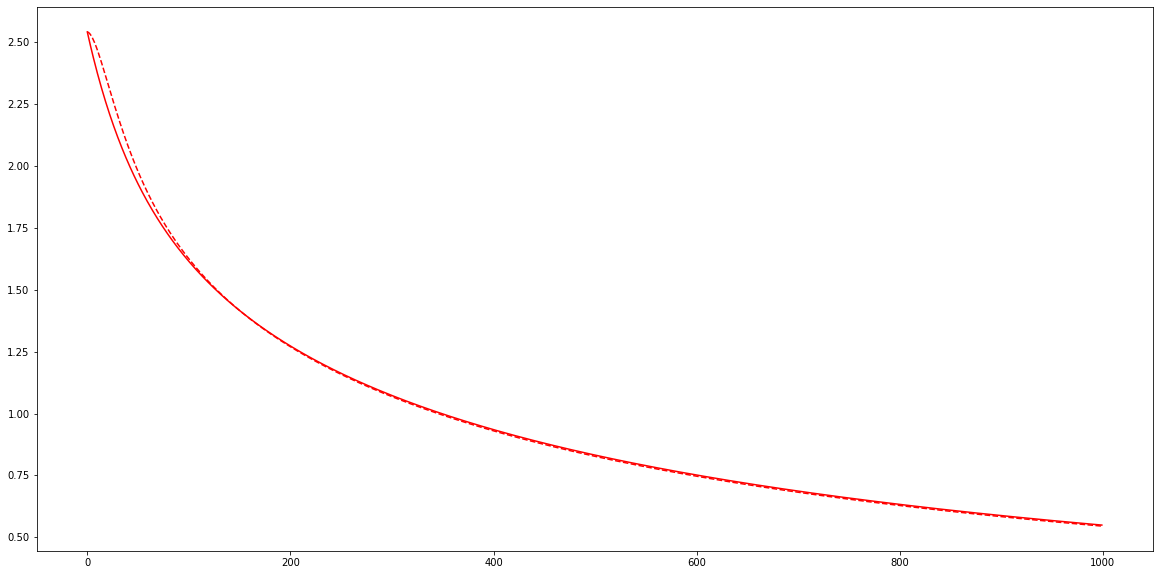

In [14]:
# learning curves
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.', 'purple']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(list_of_losses[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.savefig('Riemann_opt_first_test.pdf')

In [ ]:
tf.linalg.pinv()